In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import sys
sys.path.append('..')
from lib.plot import plot_iteration
from lib.gif import create_gif
import numpy as np
from pixel_individual import PixelIndividual
from pixel_population import Population
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
from tqdm.auto import tqdm

plt.rcParams['figure.facecolor'] = 'white'

np.set_printoptions(precision=3, suppress=True)

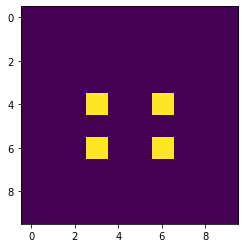

In [4]:
TARGET = np.zeros(shape=(10, 10))
TARGET[4, :] = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
TARGET[6, :] = np.array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
plt.imshow(TARGET)

## Run gridsearch experiment for suitable population and individual parameters

In [24]:
from typing import Dict, Any
from joblib import Parallel, delayed
from itertools import product
import pandas as pd
import plotly.express as px

mutation_delta = [0.1, 0.2, 0.3, 0.4]
mutation_prob = [0.1, 0.3, 0.5]
copy_top_perc = [0.02, 0.04, 0.08, 0.15]
sample_top_n = [0.1, 0.2, 0.05, 0.3, 0.4]
results = []

def optimize_with_config(mutation_delta, mutation_prob, copy_top_perc, sample_top_n) -> Dict[str, Any]:
    pop = Population(target=TARGET, popsize=30, mutation_delta=mutation_delta, mutation_prob=mutation_prob, copy_top_perc=copy_top_perc, sample_top_n=sample_top_n)
    pop.optimize(epochs=400, plot=False)
    return {
        'mutation_delta': mutation_delta, 
        'mutation_prob': mutation_prob, 
        'copy_top_perc': copy_top_perc, 
        'sample_top_n': sample_top_n, 
        'best_fitness': pop.pop[0].fitness
        }

In [25]:
param_combinations = list(product(mutation_delta, mutation_prob, copy_top_perc, sample_top_n))
result = Parallel(n_jobs=-1)(delayed(optimize_with_config)(mdelta, mprob, topp, topn) for mdelta, mprob, topp, topn in tqdm(param_combinations, total=len(param_combinations)))
results_df = pd.DataFrame(result)
results_df.to_parquet('grid_search_results.parquet')
results_df.head()

  0%|          | 0/240 [00:00<?, ?it/s]

,mutation_delta,mutation_prob,copy_top_perc,sample_top_n,best_fitness
0,0.1,0.1,0.02,0.10,469.089896
1,0.1,0.1,0.02,0.20,446.655820
2,0.1,0.1,0.02,0.05,514.730597
3,0.1,0.1,0.02,0.30,420.383905
4,0.1,0.1,0.02,0.40,386.919178


In [26]:
results_df = pd.read_parquet('grid_search_results.parquet')
results_df.sort_values('best_fitness')

,mutation_delta,mutation_prob,copy_top_perc,sample_top_n,best_fitness
39,0.1,0.3,0.15,0.40,378.537444
99,0.2,0.3,0.15,0.40,378.798450
54,0.1,0.5,0.08,0.40,380.867109
194,0.4,0.1,0.08,0.40,381.138741
34,0.1,0.3,0.08,0.40,382.284340
...,...,...,...,...,...
182,0.4,0.1,0.02,0.05,514.649624
2,0.1,0.1,0.02,0.05,514.730597
27,0.1,0.3,0.04,0.05,516.796636
52,0.1,0.5,0.08,0.05,517.420879


In [27]:
px.parallel_coordinates(results_df, color='best_fitness', labels=['mutation_delta', 'mutation_prob', 'copy_top_perc', 'sample_top_n', 'best_fitness'])

## Run full optimization 

### 4 Dots

In [12]:
pop = Population(target=TARGET, popsize=100, mutation_delta=0.04, mutation_prob=0.4, copy_top_perc=0.04, sample_top_n=0.4, stop_threshold=0.01)
pop.optimize(epochs=500, plot_frequency=20, name='4dots', show=True, plot=True)

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

![training gif](../img/4dots/training.gif)

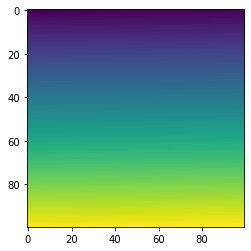

In [7]:
TARGET = np.arange(0, 1, 0.0001).reshape((100, 100))
plt.imshow(TARGET)

In [8]:
pop = Population(target=TARGET, popsize=100, mutation_delta=0.02, mutation_prob=1, copy_top_perc=0.1, sample_top_n=0.4, stop_threshold=-1)
pop.optimize(epochs=500, plot_frequency=20, name='gradient', show=True, plot=True)

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

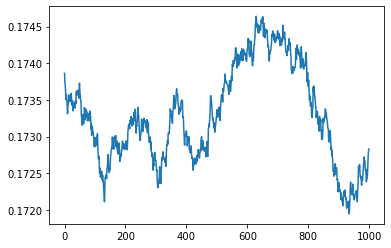

In [42]:
target = np.random.rand(20, 20, 3)
loss = []
ind = PixelIndividual(shape=(20, 20, 3), mutate_prob=1, mutate_change=0.01)
for i in range(1000):
    ind.mutate()
    ind.compute_fitness(target=target)
    loss.append(ind.fitness)
plt.plot(loss)

In [25]:
t = np.ones(shape=(10, 10)) * 0.5
t

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [73]:
base = np.zeros(shape=(10, 10))
abs(base-t).mean()

0.5

In [75]:
k = ((np.random.rand(10, 10) * 0.05) - (0.05 / 2))
base = np.clip(base + k, a_min=0, a_max=1)
l = abs(base - t).mean()
base

array([[0.016, 0.016, 0.   , 0.   , 0.004, 0.   , 0.   , 0.005, 0.   ,
        0.   ],
       [0.016, 0.   , 0.016, 0.015, 0.   , 0.003, 0.   , 0.   , 0.004,
        0.025],
       [0.027, 0.   , 0.   , 0.003, 0.   , 0.   , 0.   , 0.   , 0.005,
        0.043],
       [0.   , 0.022, 0.   , 0.036, 0.   , 0.   , 0.002, 0.   , 0.   ,
        0.035],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.005, 0.   ,
        0.023],
       [0.007, 0.   , 0.03 , 0.01 , 0.009, 0.016, 0.035, 0.011, 0.003,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.001, 0.007, 0.005, 0.034, 0.023,
        0.028],
       [0.   , 0.   , 0.   , 0.004, 0.027, 0.   , 0.027, 0.   , 0.   ,
        0.017],
       [0.   , 0.001, 0.   , 0.003, 0.   , 0.   , 0.035, 0.   , 0.   ,
        0.009],
       [0.001, 0.019, 0.   , 0.037, 0.006, 0.003, 0.035, 0.02 , 0.005,
        0.   ]])

In [83]:
0.05*0.05

0.0025000000000000005

In [87]:
k.std()

0.014236010663782371

(array([  13.,  130.,  520., 1463., 2603., 2720., 1700.,  665.,  157.,
          29.]),
 array([-0.183, -0.147, -0.111, -0.075, -0.04 , -0.004,  0.032,  0.068,
         0.104,  0.139,  0.175]),
 <BarContainer object of 10 artists>)

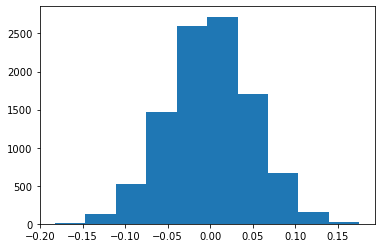

In [163]:
plt.hist(np.random.normal(size=shape).reshape(-1) * 0.05)

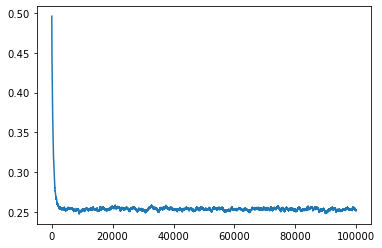

(array([1017., 1008., 1032.,  984.,  994.,  994.,  990.,  996.,  959.,
        1026.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

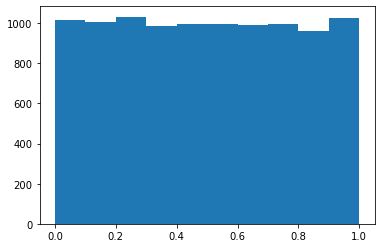

In [165]:
vals = []
means = []
shape = (100, 100)
f = 0.01
t = np.ones(shape=shape) / 2
base = np.zeros(shape=shape)
for i in range(100000):
    k = ((np.random.normal(size=shape) * f))
    # plt.hist(k.reshape(-1))
    base = np.clip(base + k, a_min=0, a_max=1)
    # base += k
    means.append(base.mean())
    l = abs(base - t).mean()
    vals.append(l)
plt.plot(vals)
# plt.plot(means)
plt.show()
np.mean(vals)
plt.hist(base.reshape(-1))

In [8]:
pop.pop[0].genes

array([[0.146, 0.134, 1.   , ..., 0.911, 0.208, 1.   ],
       [0.718, 0.308, 1.   , ..., 0.804, 0.83 , 0.215],
       [0.595, 0.896, 0.122, ..., 0.085, 0.33 , 0.192],
       ...,
       [0.871, 1.   , 1.   , ..., 0.677, 0.241, 0.096],
       [0.671, 0.445, 0.368, ..., 0.917, 0.707, 0.122],
       [0.466, 0.597, 1.   , ..., 0.884, 0.715, 0.303]], dtype=float32)

[PixelIndividual(shape=(100, 100), fitness=855.5305), PixelIndividual(shape=(100, 100), fitness=862.8768), PixelIndividual(shape=(100, 100), fitness=862.8861)]
[PixelIndividual(shape=(100, 100), fitness=888.1972), PixelIndividual(shape=(100, 100), fitness=891.9923), PixelIndividual(shape=(100, 100), fitness=892.2069)]
[PixelIndividual(shape=(100, 100), fitness=903.1850), PixelIndividual(shape=(100, 100), fitness=909.1821), PixelIndividual(shape=(100, 100), fitness=909.9819)]
[PixelIndividual(shape=(100, 100), fitness=922.9867), PixelIndividual(shape=(100, 100), fitness=925.3957), PixelIndividual(shape=(100, 100), fitness=926.6624)]
[PixelIndividual(shape=(100, 100), fitness=927.3484), PixelIndividual(shape=(100, 100), fitness=929.1606), PixelIndividual(shape=(100, 100), fitness=932.4565)]
[PixelIndividual(shape=(100, 100), fitness=939.0807), PixelIndividual(shape=(100, 100), fitness=939.1428), PixelIndividual(shape=(100, 100), fitness=941.0378)]
[PixelIndividual(shape=(100, 100), fitne

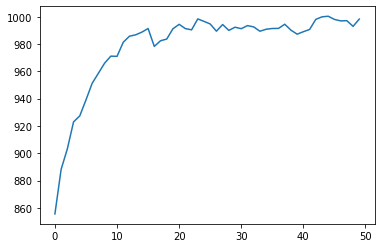

In [6]:
from copy import deepcopy
t = np.ones(shape=(100, 100)) * 0.5
pop = Population(target=t, popsize=30, mutation_delta=0.1, mutation_prob=1, copy_top_perc=0, sample_top_n=0.5, stop_threshold=0.01)
# pop.pop = [deepcopy(pop.pop[0]) for i in range(30)]
min_loss = []
for i in range(50):
    pop.mutate_pop()
    pop.calculate_fitness()
    pop.sort_population()
    print(pop.pop[:3])
    min_loss.append(pop.get_best().fitness)
plt.plot(min_loss)

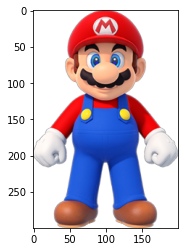

In [9]:
TARGET = image.imread('../targets/mario.png')
# TARGET = (TARGET[..., :3] * 256)
TARGET = cv2.resize(TARGET, (200, 300))
plt.imshow(TARGET)

In [20]:
pop = Population(target=TARGET, popsize=100, mutation_delta=0.3, mutation_prob=0.4, copy_top_perc=0.1, sample_top_n=0.4, stop_threshold=-1)
pop.optimize(epochs=15000, plot_frequency=20, name='mario', show=True, plot=True)

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
create_gif('img/gradient/iters', fp_out='img/gradient/training.gif')

Image saved at img/gradient/training.gif.


In [12]:
create_gif('../polygon/img/rick_polygons/iters', fp_out='../polygon/img/rick_polygons/training_gif.gif')

Image saved at ../polygon/img/rick_polygons/training_gif.gif.
